In [1]:
import pandas as pd
import time
import numpy as np
import re 
from datetime import datetime as dt
from datetime import timedelta 
import pickle
from random import *
from pysolar.solar import *
import shap

#plotting
from IPython.display import HTML, display
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter
%matplotlib inline

#modeling
import xgboost as xgb
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold,StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve

# Load Data

In [2]:
df = pd.read_csv('df_all_processed.csv')
ndf = pd.read_csv('ndf.csv')
ndf_tmc=pd.read_csv('ndf_TMC.csv')
ramp = pd.read_csv('ramp_exit.csv')

In [3]:
pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',300)

In [4]:
df = pd.merge(df, ramp, how = 'left', left_on = 'TMC', right_on = 'tmc')
ndf = pd.merge(ndf, ramp, how = 'left', left_on = 'TMC', right_on = 'tmc')

# Vertical Profile for ndf

grade

In [5]:
g = pd.read_csv('NJ3_grade.csv')
g.index = pd.IntervalIndex.from_arrays(g['MP ST'],g['MP END'],closed='both')

In [6]:
ndf['grade'] = ndf['MP'].apply(lambda x: g.iloc[g.index.get_loc(x)]['Grade EB'])
ndf['grade'] = np.where(ndf['direction']=='W', ndf['grade']*-1, ndf['grade'])

In [7]:
ndf = ndf.reset_index(drop=True)

# Review Features

In [8]:
pd.DataFrame(df.columns)

,0
0,Unnamed: 0
1,DAY
2,KILLED
3,INJURED
4,PED_KILL
5,PED_INJ
6,SEVERITY
7,ALCOHOL
8,HAZMAT
9,CRASH_TYPE


In [9]:
pd.DataFrame(ndf.columns)

,0
0,Unnamed: 0
1,index
2,timestamp
3,TMC
4,tmc_dn1
5,tmc_dn2
6,tmc_up1
7,tmc_up2
8,tmc_miles
9,tmc_dn1_miles


# Additional Processing

In [10]:
#Density - Flow - Speed
df['density'] = (df['VOL']+df['TRK'])/df['spd']
ndf['density'] = (ndf['VOL']+ndf['TRK'])/ndf['spd']

In [11]:
df['target'] = 1
ndf['target'] = 0

# Continuous Features

* speed (spd)
* solar_altitude
* solar_azimuth
* speed difference with downstream link 1 (dn1_spd_diff)
* speed difference with upstream link 1 (up1_spd_diff)
* mean speed for the previous 15-min (avg_spd_15min)
* mean speed for the previous 10-min (avg_spd_10min)
* mean speed for the previous 5-min (avg_spd_5min)
* speed standard deviation (SD) for the previous 15-min (std_15min)
* speed standard deviation (SD) for the previous 10-min (std_10min)
* speed standard deviation (SD) for the previous 5-min (std_5min)
* coefficient of variation (CV) for the previous 15-min (cv_15min)
* coefficient of variation (CV) for the previous 10-min (cv_10min)
* coefficient of variation (CV) for the previous 5-min (cv_5min)
* measn speed difference between upstream and downstream link for the previous 5-min (avg_spd_diff_up1dn1_5min)
* High Temperature (High)
* Low Temperature (Low)
* Precipitation amount (Precip.)
* Snow 
* Snow depth (Snow d.)
* Link Capacity (CAPLINK)
* Hourly volume (VOL)
* Hourly truck volume (TRK) 
* Population Density (Pop_Dense)
* Vertical Profile (grade)
* Density (Density)

In [12]:
float_feature_names = [
    'spd',
    'solar_altitude',
    'solar_azimuth',
    'dn1_spd_diff',
    'up1_spd_diff',
    'avg_spd_15min',
    'avg_spd_10min',
    'avg_spd_5min',
    'std_15min',
    'std_10min',
    'std_5min',
    'cv_15min',
    'cv_10min',
    'cv_5min',
    'avg_spd_diff_up1dn1_5min',
    'High',
    'Low',
    'Precip.',
    'Snow d.',
    'CAPLINK',
    'VOL',
    'TRK',
    'Pop_Dense',
    'density',
    'grade'
   
]

# Binary Features

In [13]:
binary_feature_names = [
    'direction_',
    'RAMP'
]

# Temporal Features

In [14]:
temporal_feature_names = [
    'hour',
    'month',
    'weekday'
]

# Reponse Feature

In [15]:
res_feature_names = [
    'target'
]

In [16]:
df1 = df.xs(float_feature_names+binary_feature_names+temporal_feature_names+res_feature_names, axis=1)
ndf1 = ndf.xs(float_feature_names+binary_feature_names+temporal_feature_names+res_feature_names, axis=1)

In [17]:
df_ = pd.concat([df1, ndf1])
df_ = df_.sample(frac=1).reset_index(drop=True)

In [18]:
df_ = df_.dropna()

In [19]:
df__=pd.concat([df1, ndf1])
df__=df__.sample(frac=1).reset_index(drop=True)

In [20]:
df__.isna().sum(axis=0)

spd                         458
solar_altitude                0
solar_azimuth                 0
dn1_spd_diff                508
up1_spd_diff                519
avg_spd_15min                57
avg_spd_10min                61
avg_spd_5min                 94
std_15min                    65
std_10min                    81
std_5min                    162
cv_15min                     65
cv_10min                     81
cv_5min                     162
avg_spd_diff_up1dn1_5min    191
High                         14
Low                          14
Precip.                      14
Snow d.                      14
CAPLINK                       0
VOL                           0
TRK                           0
Pop_Dense                     0
density                     458
grade                         0
direction_                    0
RAMP                          0
hour                          0
month                         0
weekday                       0
target                        0
dtype: i

In [21]:
df_.isna().sum(axis=0)

spd                         0
solar_altitude              0
solar_azimuth               0
dn1_spd_diff                0
up1_spd_diff                0
avg_spd_15min               0
avg_spd_10min               0
avg_spd_5min                0
std_15min                   0
std_10min                   0
std_5min                    0
cv_15min                    0
cv_10min                    0
cv_5min                     0
avg_spd_diff_up1dn1_5min    0
High                        0
Low                         0
Precip.                     0
Snow d.                     0
CAPLINK                     0
VOL                         0
TRK                         0
Pop_Dense                   0
density                     0
grade                       0
direction_                  0
RAMP                        0
hour                        0
month                       0
weekday                     0
target                      0
dtype: int64

In [20]:
float_features = df_.xs(float_feature_names,axis=1).values
# Use scikit-learn's StandardScaler
scaler = StandardScaler()
float_scaled = scaler.fit_transform(float_features)

df_[float_feature_names] = float_scaled

with open('scalers.pkl','wb') as fp:
    pickle.dump(scaler,fp)

In [21]:
df_.dtypes

spd                         float64
solar_altitude              float64
solar_azimuth               float64
dn1_spd_diff                float64
up1_spd_diff                float64
avg_spd_15min               float64
avg_spd_10min               float64
avg_spd_5min                float64
std_15min                   float64
std_10min                   float64
std_5min                    float64
cv_15min                    float64
cv_10min                    float64
cv_5min                     float64
avg_spd_diff_up1dn1_5min    float64
High                        float64
Low                         float64
Precip.                     float64
Snow d.                     float64
CAPLINK                     float64
VOL                         float64
TRK                         float64
Pop_Dense                   float64
density                     float64
grade                       float64
direction_                   object
RAMP                          int64
hour                        

In [22]:
cat_feature = ['direction_','RAMP', 'hour', 'month', 'weekday']
df_ = pd.get_dummies(df_,columns=cat_feature)

# Get the one-hot variable names
#cat_feature_names = pd.get_dummies(df_[cat_feature],columns=cat_feature).columns.tolist()
df_.head()

,spd,solar_altitude,solar_azimuth,dn1_spd_diff,up1_spd_diff,avg_spd_15min,avg_spd_10min,avg_spd_5min,std_15min,std_10min,std_5min,cv_15min,cv_10min,cv_5min,avg_spd_diff_up1dn1_5min,High,Low,Precip.,Snow d.,CAPLINK,VOL,TRK,Pop_Dense,density,grade,target,direction__E,direction__W,RAMP_0,RAMP_1,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0.926731,0.685900,0.795435,-0.243902,0.124574,0.462962,0.603938,0.717311,0.240138,0.035911,-0.812199,-0.082815,-0.192944,-0.646526,1.004422,-0.182781,-0.447842,7.729834,-0.174637,1.829631,1.657807,0.252432,0.161465,0.093699,-0.300060,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1.071772,0.983568,0.194475,0.985271,-0.034168,0.882172,0.948309,1.042366,-0.246588,-0.125428,-0.534810,-0.390860,-0.317376,-0.499106,0.523345,-1.348976,-1.420119,-0.371066,-0.174637,1.829631,0.846299,-0.359484,-1.588366,-0.142914,-0.241677,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.346570,0.502265,-0.611772,-1.319428,0.283317,0.392252,0.386834,0.421807,-0.822826,-0.598842,-0.812199,-0.648745,-0.520948,-0.646526,-0.334226,-0.023755,-0.321273,-0.371066,-0.174637,-0.545188,0.320560,0.388046,0.161465,-0.125946,1.042753,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,-0.016032,1.242652,0.409721,0.985271,-0.192910,0.258602,0.209033,0.067202,-0.122248,0.261748,0.019970,-0.247298,-0.000098,-0.092430,0.920757,1.306767,1.168786,-0.371066,-0.174637,-0.496931,0.387648,0.679120,0.161465,-0.023576,2.181224,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
4,1.071772,-0.595863,-1.402899,0.524331,-0.034168,0.856918,0.858473,1.012816,-0.250994,0.006390,-0.812199,-0.390419,-0.240978,-0.646526,0.293265,1.200750,1.398911,1.091973,-0.174637,-0.545188,-0.975403,0.417815,0.161465,-0.518730,-1.350956,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [23]:
X = df_.drop('target', axis=1).values
y = df_['target'].values
feature_names = df_.drop('target',axis =1).columns.tolist()

In [46]:
feature_names

['spd',
 'solar_altitude',
 'solar_azimuth',
 'dn1_spd_diff',
 'up1_spd_diff',
 'avg_spd_15min',
 'avg_spd_10min',
 'avg_spd_5min',
 'std_15min',
 'std_10min',
 'std_5min',
 'cv_15min',
 'cv_10min',
 'cv_5min',
 'avg_spd_diff_up1dn1_5min',
 'High',
 'Low',
 'Precip.',
 'Snow d.',
 'CAPLINK',
 'VOL',
 'TRK',
 'Pop_Dense',
 'density',
 'grade',
 'direction__E',
 'direction__W',
 'RAMP_0',
 'RAMP_1',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle = True, random_state=10)

print (X_train.shape,y_train.shape)
print (X_test.shape,y_test.shape)
X_train = xgb.DMatrix(X_train,label=y_train,feature_names=feature_names)
X_test =  xgb.DMatrix(X_test,label=y_test,feature_names=feature_names)
# params = {
#     'n_estimators': 2000,
#     'max_depth':6,
#     'reg_lambda': 0.0,
#     'reg_alpha':1.0
# }

params = {
    'max_depth':6,
    'min_child_weight': 5.0,
    'reg_lambda': 1.0,
    'reg_alpha':0.0,
    'scale_pos_weight':1.0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'eta':0.5
}



booster = xgb.train(params,X_train)

y_pred_test = np.round(booster.predict(X_test))
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
print ('Test F1:',f1_score(y_test,y_pred_test))
print ('Test Precision:',precision_score(y_test,y_pred_test))
print ('Test Recall:',recall_score(y_test,y_pred_test))
y_pred_test = booster.predict(X_test)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))

num_accidents_predicted_correctly = np.sum((y_test > 0) * (y_pred_test > 0))
num_accidents = np.sum(y_test > 0)

print ('Fraction Predicted:',num_accidents_predicted_correctly/float(num_accidents))
print ('Fraction False Alarm',(np.sum(y_pred_test>0) - num_accidents_predicted_correctly)/float(num_accidents))
y_pred_train = np.round(booster.predict(X_train))
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train F1:',f1_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = booster.predict(X_train)
print ('Train AUC:',roc_auc_score(y_train,y_pred_train))

(19267, 72) (19267,)
(10376, 72) (10376,)
Test Accuracy: 0.8553392444101773
Test F1: 0.4800831312781434
Test Precision: 0.7590361445783133
Test Recall: 0.35106382978723405
Test AUC: 0.8340808515944121
Fraction Predicted: 1.0
Fraction False Alarm 4.256332320162107
Train Accuracy: 0.8740333212228162
Train F1: 0.5407757805108798
Train Precision: 0.8400940623162846
Train Recall: 0.39871651785714285
Train AUC: 0.8820175668632322


In [30]:
booster = xgb.train(params,X_train,
    evals = [(X_test, 'eval')],
    num_boost_round=3000,
    early_stopping_rounds=25
)

[0]	eval-auc:0.749579
Will train until eval-auc hasn't improved in 25 rounds.
[1]	eval-auc:0.766646
[2]	eval-auc:0.800836
[3]	eval-auc:0.806598
[4]	eval-auc:0.811804
[5]	eval-auc:0.817909
[6]	eval-auc:0.821102
[7]	eval-auc:0.832954
[8]	eval-auc:0.833861
[9]	eval-auc:0.839093
[10]	eval-auc:0.83802
[11]	eval-auc:0.843512
[12]	eval-auc:0.856006
[13]	eval-auc:0.855899
[14]	eval-auc:0.855866
[15]	eval-auc:0.855775
[16]	eval-auc:0.855497
[17]	eval-auc:0.854841
[18]	eval-auc:0.855601
[19]	eval-auc:0.854775
[20]	eval-auc:0.853796
[21]	eval-auc:0.853852
[22]	eval-auc:0.852982
[23]	eval-auc:0.853002
[24]	eval-auc:0.852476
[25]	eval-auc:0.85225
[26]	eval-auc:0.851832
[27]	eval-auc:0.851582
[28]	eval-auc:0.851048
[29]	eval-auc:0.850916
[30]	eval-auc:0.850031
[31]	eval-auc:0.850174
[32]	eval-auc:0.850684
[33]	eval-auc:0.849391
[34]	eval-auc:0.848292
[35]	eval-auc:0.847945
[36]	eval-auc:0.847842
[37]	eval-auc:0.847002
Stopping. Best iteration:
[12]	eval-auc:0.856006



Text(0, 0.5, 'Features')

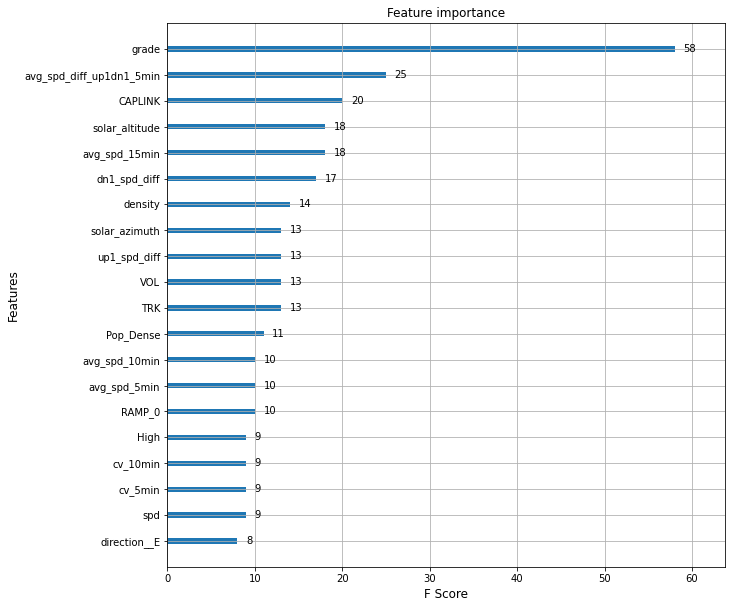

In [28]:
plt.figure(figsize=(10,10))
xgb.plot_importance(booster,ax=plt.gca(),importance_type='weight', max_num_features=20)
plt.xlabel('F Score', fontsize=12)
plt.ylabel('Features', fontsize=12)

Text(0, 0.5, 'Features')

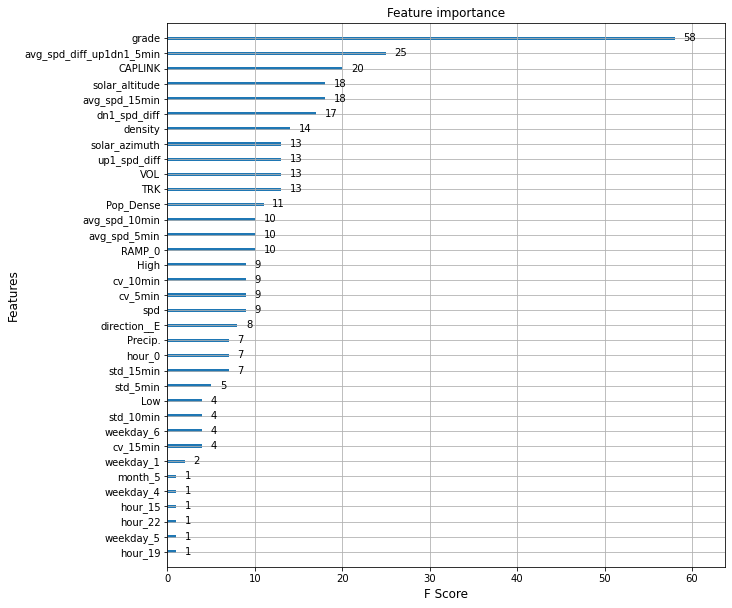

In [29]:
plt.figure(figsize=(10,10))
xgb.plot_importance(booster,ax=plt.gca(),importance_type='weight')
plt.xlabel('F Score', fontsize=12)
plt.ylabel('Features', fontsize=12)

In [35]:
X = df_.drop(['target', 'direction_'],axis=1)
y = df_['target']

In [37]:
xgb_full = xgb.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test, label=y_test)

In [38]:
params = {
    'max_depth':6,
    'min_child_weight': 5.0,
    'reg_lambda': 1.0,
    'reg_alpha':0.0,
    'scale_pos_weight':1.0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'eta':0.5
}
model_train = xgb.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)

[0]	test-auc:0.759435
[1000]	test-auc:0.836591
[2000]	test-auc:0.834731
[3000]	test-auc:0.834784
[4000]	test-auc:0.834621
[5000]	test-auc:0.834218
[6000]	test-auc:0.833854
[7000]	test-auc:0.833724
[8000]	test-auc:0.833487
[9000]	test-auc:0.833302
[9999]	test-auc:0.833302


In [39]:
model = xgb.train(params, xgb_full, 5000, evals = [(xgb_full, "test")], verbose_eval=1000)

[0]	test-auc:0.759824
[1000]	test-auc:1
[2000]	test-auc:1
[3000]	test-auc:1
[4000]	test-auc:1
[4999]	test-auc:1


In [40]:
shap_values = shap.TreeExplainer(model).shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


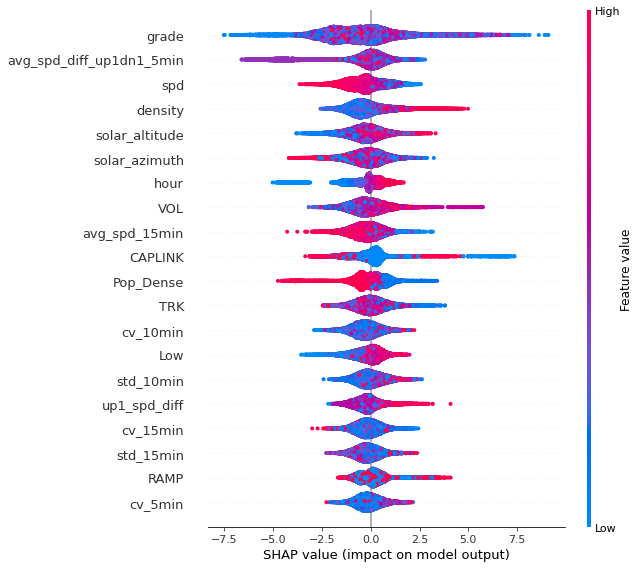

In [41]:
shap.summary_plot(shap_values, X)

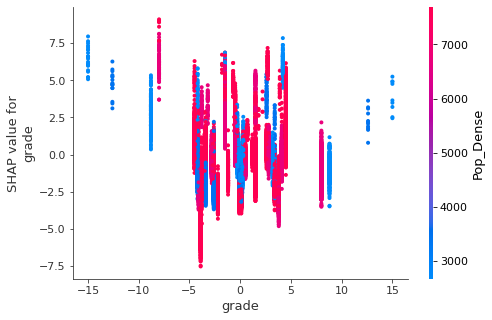

In [52]:
shap.dependence_plot("grade", shap_values, X)

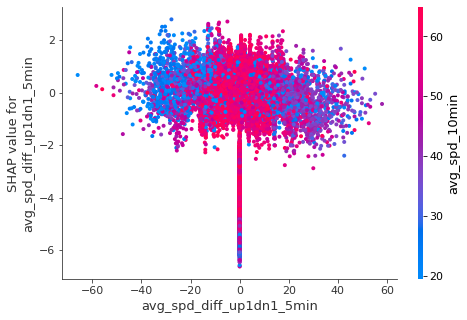

In [44]:
shap.dependence_plot("avg_spd_diff_up1dn1_5min", shap_values, X)

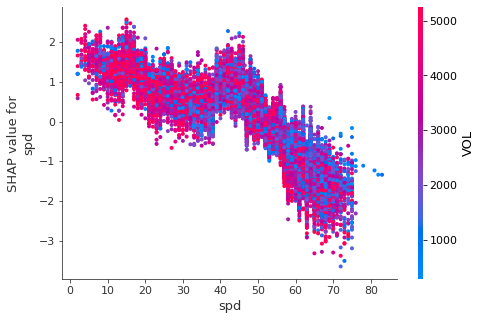

In [45]:
shap.dependence_plot("spd", shap_values, X)

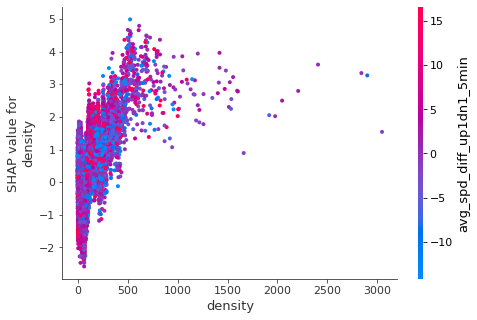

In [46]:
shap.dependence_plot("density", shap_values, X)

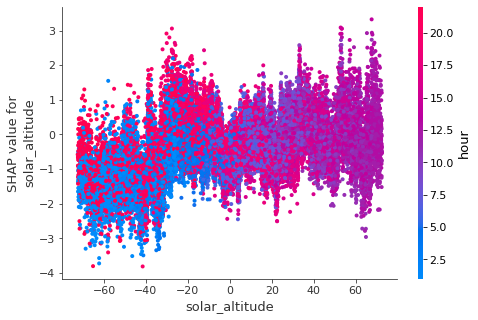

In [47]:
shap.dependence_plot("solar_altitude", shap_values, X)

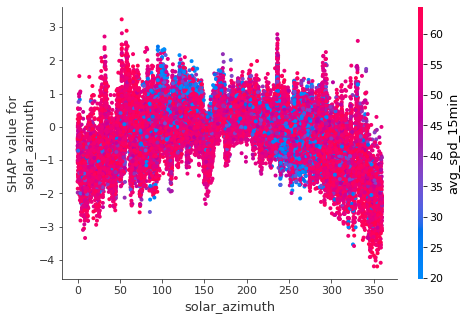

In [48]:
shap.dependence_plot("solar_azimuth", shap_values, X)

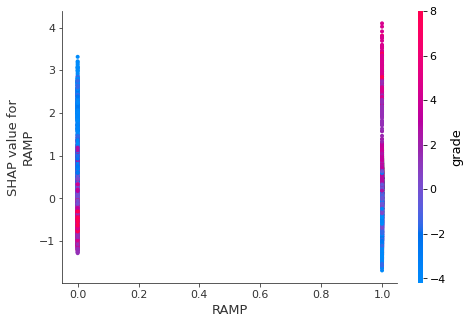

In [49]:
shap.dependence_plot("RAMP", shap_values, X)

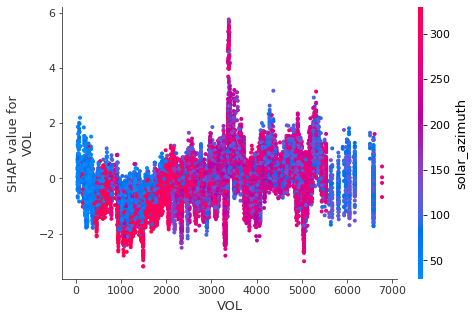

In [50]:
shap.dependence_plot("VOL", shap_values, X)

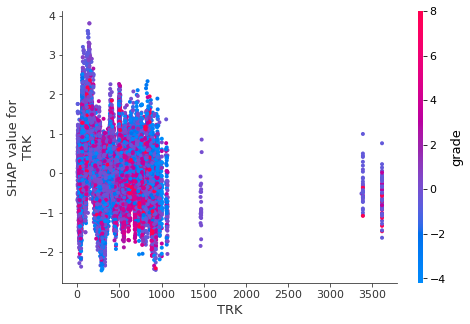

In [51]:
shap.dependence_plot("TRK", shap_values, X)

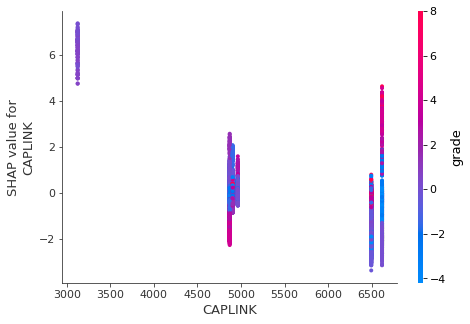

In [53]:
shap.dependence_plot("CAPLINK", shap_values, X)

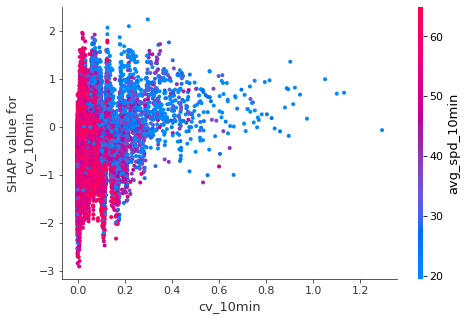

In [54]:
shap.dependence_plot("cv_10min", shap_values, X)

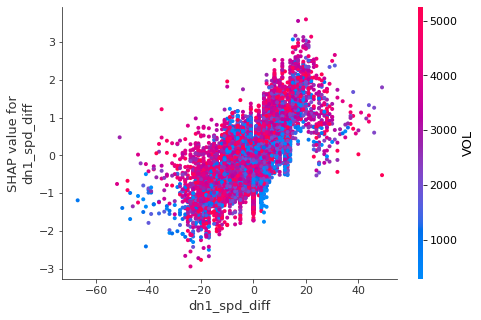

In [56]:
shap.dependence_plot("dn1_spd_diff", shap_values, X)

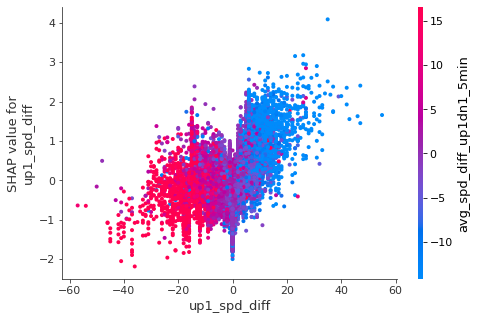

In [57]:
shap.dependence_plot("up1_spd_diff", shap_values, X)

In [33]:
print(df_.groupby('target').size())

target
0    24085
1     5558
dtype: int64


# SMOTE

In [54]:
from collections import Counter
from imblearn.over_sampling import SMOTE 

x1 = df_.drop('target', axis=1)
y1 = df_['target']

'''Increase the crash samples from 5558 to 10000'''

sm = SMOTE(random_state=42,sampling_strategy={1:10000})
X_res, y_res = sm.fit_sample(x1, y1)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({0: 24085, 1: 10000})


In [55]:
xtrain, xtest, ytrain, ytest = train_test_split(X_res, y_res, test_size=0.30, random_state=0)
print('xtrain shape')
print(xtrain.shape)
print('xtest shape')
print(xtest.shape)

xtrain shape
(23859, 72)
xtest shape
(10226, 72)


In [56]:
'''Extreme Gradient Boost Algorithm on reduced dimensions data'''

from xgboost.sklearn import XGBClassifier

# Create the XGB classifier, xgb_model.
xgb_model = XGBClassifier()

# List the default parameters.
print(xgb_model.get_xgb_params())

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 1, 'verbosity': 1}


In [57]:
# Train and evaluate.
xgb_model.fit(xtrain, ytrain, eval_metric=['error'], eval_set=[((xtrain, ytrain)),(xtest, ytest)])

[0]	validation_0-error:0.241167	validation_1-error:0.239977
[1]	validation_0-error:0.239574	validation_1-error:0.238119
[2]	validation_0-error:0.237562	validation_1-error:0.235869
[3]	validation_0-error:0.236724	validation_1-error:0.234794
[4]	validation_0-error:0.237437	validation_1-error:0.235185
[5]	validation_0-error:0.236808	validation_1-error:0.234207
[6]	validation_0-error:0.237395	validation_1-error:0.235478
[7]	validation_0-error:0.235551	validation_1-error:0.233718
[8]	validation_0-error:0.236431	validation_1-error:0.2345
[9]	validation_0-error:0.235718	validation_1-error:0.233718
[10]	validation_0-error:0.234	validation_1-error:0.230686
[11]	validation_0-error:0.233664	validation_1-error:0.230686
[12]	validation_0-error:0.234084	validation_1-error:0.230589
[13]	validation_0-error:0.23379	validation_1-error:0.230686
[14]	validation_0-error:0.232072	validation_1-error:0.230295
[15]	validation_0-error:0.23203	validation_1-error:0.230882
[16]	validation_0-error:0.231862	validati

XGBClassifier()

In [58]:
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

y_pred = xgb_model.predict(xtest)  #predicts
print('confusion matrix')
print(metrics.confusion_matrix(ytest, y_pred))
print('classification report')
print(metrics.classification_report(ytest, y_pred))
print("-----------------------------------------------------------------------------------------")
print("Accuracy is :")
print(metrics.accuracy_score(ytest, y_pred))
print('Area under the curve : %f' % (metrics.roc_auc_score(ytest, y_pred)))

confusion matrix
[[6864  400]
 [1356 1606]]
classification report
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7264
           1       0.80      0.54      0.65      2962

    accuracy                           0.83     10226
   macro avg       0.82      0.74      0.77     10226
weighted avg       0.83      0.83      0.82     10226

-----------------------------------------------------------------------------------------
Accuracy is :
0.8282808527283395
Area under the curve : 0.743568


In [59]:
print ('Test Accuracy:',accuracy_score(ytest,y_pred))
print ('Test F1:',f1_score(ytest,y_pred))
print ('Test Precision:',precision_score(ytest,y_pred))
print ('Test Recall:',recall_score(ytest,y_pred))

Test Accuracy: 0.8282808527283395
Test F1: 0.6465378421900161
Test Precision: 0.8005982053838484
Test Recall: 0.5422012153950033


In [60]:
params = {
    'max_depth':6,
    'min_child_weight': 5.0,
    'reg_lambda': 1.0,
    'reg_alpha':0.0,
    'scale_pos_weight':1.0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'eta':0.5
}


In [61]:
xgb_model1 = XGBClassifier().set_params(max_depth = 6, min_child_weight = 5, reg_lambda = 1, reg_alpha =0,
                                       scale_pos_weight = 1, objective = 'binary:logistic', eta = 0.4)

In [62]:
xgb_model1.fit(xtrain, ytrain, eval_metric=['error'], eval_set=[((xtrain, ytrain)),(xtest, ytest)])

[0]	validation_0-error:0.229473	validation_1-error:0.226677
[1]	validation_0-error:0.220294	validation_1-error:0.219343
[2]	validation_0-error:0.208642	validation_1-error:0.209857
[3]	validation_0-error:0.214929	validation_1-error:0.216409
[4]	validation_0-error:0.206002	validation_1-error:0.207217
[5]	validation_0-error:0.206882	validation_1-error:0.207999
[6]	validation_0-error:0.205164	validation_1-error:0.20575
[7]	validation_0-error:0.201308	validation_1-error:0.201545
[8]	validation_0-error:0.202188	validation_1-error:0.203501
[9]	validation_0-error:0.197284	validation_1-error:0.199198
[10]	validation_0-error:0.196027	validation_1-error:0.198025
[11]	validation_0-error:0.193554	validation_1-error:0.194993
[12]	validation_0-error:0.192045	validation_1-error:0.194504
[13]	validation_0-error:0.189698	validation_1-error:0.191179
[14]	validation_0-error:0.18689	validation_1-error:0.187463
[15]	validation_0-error:0.18492	validation_1-error:0.187072
[16]	validation_0-error:0.183914	vali

XGBClassifier(eta=0.4, max_depth=6, min_child_weight=5)

In [63]:
warnings.filterwarnings("ignore")

y_pred1 = xgb_model1.predict(xtest)  #predicts
print('confusion matrix')
print(metrics.confusion_matrix(ytest, y_pred1))
print('classification report')
print(metrics.classification_report(ytest, y_pred1))
print("-----------------------------------------------------------------------------------------")
print("Accuracy is :")
print(metrics.accuracy_score(ytest, y_pred1))
print('Area under the curve : %f' % (metrics.roc_auc_score(ytest, y_pred1)))

confusion matrix
[[6986  278]
 [1002 1960]]
classification report
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      7264
           1       0.88      0.66      0.75      2962

    accuracy                           0.87     10226
   macro avg       0.88      0.81      0.83     10226
weighted avg       0.87      0.87      0.87     10226

-----------------------------------------------------------------------------------------
Accuracy is :
0.8748288675924115
Area under the curve : 0.811722


In [64]:
warnings.filterwarnings("ignore")

y_pred1 = xgb_model1.predict(xtest)  #predicts
print('confusion matrix')
print(metrics.confusion_matrix(ytest, y_pred1))
print('classification report')
print(metrics.classification_report(ytest, y_pred1))
print("-----------------------------------------------------------------------------------------")
print("Accuracy is :")
print(metrics.accuracy_score(ytest, y_pred1))
print('Area under the curve : %f' % (metrics.roc_auc_score(ytest, y_pred1)))

confusion matrix
[[6986  278]
 [1002 1960]]
classification report
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      7264
           1       0.88      0.66      0.75      2962

    accuracy                           0.87     10226
   macro avg       0.88      0.81      0.83     10226
weighted avg       0.87      0.87      0.87     10226

-----------------------------------------------------------------------------------------
Accuracy is :
0.8748288675924115
Area under the curve : 0.811722


In [65]:
print ('Test Accuracy:',accuracy_score(ytest,y_pred1))
print ('Test F1:',f1_score(ytest,y_pred1))
print ('Test Precision:',precision_score(ytest,y_pred1))
print ('Test Recall:',recall_score(ytest,y_pred1))

Test Accuracy: 0.8748288675924115
Test F1: 0.7538461538461537
Test Precision: 0.8757819481680071
Test Recall: 0.6617150573936529


## SMOTE Senario 2
12500

In [66]:
from collections import Counter
from imblearn.over_sampling import SMOTE 

x2 = df_.drop('target', axis=1)
y2 = df_['target']

'''Increase the crash samples from 5558 to 10000'''

sm = SMOTE(random_state=42,sampling_strategy={1:12500})
X_res1, y_res1 = sm.fit_sample(x2, y2)
print('Resampled dataset shape {}'.format(Counter(y_res1)))

Resampled dataset shape Counter({0: 24085, 1: 12500})


In [67]:
xtrain1, xtest1, ytrain1, ytest1 = train_test_split(X_res1, y_res1, test_size=0.30, random_state=10)
print('xtrain shape')
print(xtrain1.shape)
print('xtest shape')
print(xtest1.shape)

xtrain shape
(25609, 72)
xtest shape
(10976, 72)


In [68]:
xgb_model1.fit(xtrain1, ytrain1, eval_metric=['error'], eval_set=[((xtrain1, ytrain1)),(xtest1, ytest1)])

[0]	validation_0-error:0.241321	validation_1-error:0.248633
[1]	validation_0-error:0.227811	validation_1-error:0.230594
[2]	validation_0-error:0.224921	validation_1-error:0.227952
[3]	validation_0-error:0.216643	validation_1-error:0.220937
[4]	validation_0-error:0.212933	validation_1-error:0.218203
[5]	validation_0-error:0.211371	validation_1-error:0.216837
[6]	validation_0-error:0.210785	validation_1-error:0.215106
[7]	validation_0-error:0.208091	validation_1-error:0.213648
[8]	validation_0-error:0.208052	validation_1-error:0.212464
[9]	validation_0-error:0.205865	validation_1-error:0.212099
[10]	validation_0-error:0.202351	validation_1-error:0.209548
[11]	validation_0-error:0.200554	validation_1-error:0.206906
[12]	validation_0-error:0.196806	validation_1-error:0.202168
[13]	validation_0-error:0.193213	validation_1-error:0.199162
[14]	validation_0-error:0.192159	validation_1-error:0.197249
[15]	validation_0-error:0.19048	validation_1-error:0.195244
[16]	validation_0-error:0.185638	va

XGBClassifier(eta=0.4, max_depth=6, min_child_weight=5)

In [69]:
warnings.filterwarnings("ignore")

y_pred1 = xgb_model1.predict(xtest1)  #predicts
print('confusion matrix')
print(metrics.confusion_matrix(ytest1, y_pred1))
print('classification report')
print(metrics.classification_report(ytest1, y_pred1))
print("-----------------------------------------------------------------------------------------")
print("Accuracy is :")
print(metrics.accuracy_score(ytest1, y_pred1))
print('Area under the curve : %f' % (metrics.roc_auc_score(ytest1, y_pred1)))

confusion matrix
[[6891  284]
 [1029 2772]]
classification report
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      7175
           1       0.91      0.73      0.81      3801

    accuracy                           0.88     10976
   macro avg       0.89      0.84      0.86     10976
weighted avg       0.88      0.88      0.88     10976

-----------------------------------------------------------------------------------------
Accuracy is :
0.8803753644314869
Area under the curve : 0.844850


## SMOTE Senario 3
15000

In [70]:
from collections import Counter
from imblearn.over_sampling import SMOTE 

x3 = df_.drop('target', axis=1)
y3 = df_['target']

'''Increase the crash samples from 5558 to 10000'''

sm = SMOTE(random_state=42,sampling_strategy={1:15000})
X_res2, y_res2 = sm.fit_sample(x3, y3)
print('Resampled dataset shape {}'.format(Counter(y_res2)))

Resampled dataset shape Counter({0: 24085, 1: 15000})


In [71]:
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(X_res2, y_res2, test_size=0.30, random_state=20)
print('xtrain shape')
print(xtrain2.shape)
print('xtest shape')
print(xtest2.shape)

xtrain shape
(27359, 72)
xtest shape
(11726, 72)


In [72]:
xgb_model1.fit(xtrain2, ytrain2, eval_metric=['error'], eval_set=[((xtrain2, ytrain2)),(xtest2, ytest2)])

[0]	validation_0-error:0.270514	validation_1-error:0.270595
[1]	validation_0-error:0.261084	validation_1-error:0.260959
[2]	validation_0-error:0.235243	validation_1-error:0.233328
[3]	validation_0-error:0.226653	validation_1-error:0.226079
[4]	validation_0-error:0.217113	validation_1-error:0.216016
[5]	validation_0-error:0.220366	validation_1-error:0.218745
[6]	validation_0-error:0.214153	validation_1-error:0.212519
[7]	validation_0-error:0.21174	validation_1-error:0.209705
[8]	validation_0-error:0.208999	validation_1-error:0.207317
[9]	validation_0-error:0.206842	validation_1-error:0.203053
[10]	validation_0-error:0.207244	validation_1-error:0.206891
[11]	validation_0-error:0.201396	validation_1-error:0.199557
[12]	validation_0-error:0.199532	validation_1-error:0.198618
[13]	validation_0-error:0.19182	validation_1-error:0.191114
[14]	validation_0-error:0.191527	validation_1-error:0.190517
[15]	validation_0-error:0.186337	validation_1-error:0.1854
[16]	validation_0-error:0.182463	valid

XGBClassifier(eta=0.4, max_depth=6, min_child_weight=5)

In [73]:
warnings.filterwarnings("ignore")

y_pred2 = xgb_model1.predict(xtest2)  #predicts
print('confusion matrix')
print(metrics.confusion_matrix(ytest2, y_pred2))
print('classification report')
print(metrics.classification_report(ytest2, y_pred2))
print("-----------------------------------------------------------------------------------------")
print("Accuracy is :")
print(metrics.accuracy_score(ytest2, y_pred2))
print('Area under the curve : %f' % (metrics.roc_auc_score(ytest2, y_pred2)))

confusion matrix
[[6942  318]
 [ 997 3469]]
classification report
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      7260
           1       0.92      0.78      0.84      4466

    accuracy                           0.89     11726
   macro avg       0.90      0.87      0.88     11726
weighted avg       0.89      0.89      0.89     11726

-----------------------------------------------------------------------------------------
Accuracy is :
0.8878560463926317
Area under the curve : 0.866478


In [74]:
# Get numerical feature importances
importances_xgb = list(xgb_model.feature_importances_)

# List of tuples with variable and importance
feature_importances_xgb = [(feature, round(importance, 5)) for feature, importance in zip(xtrain.columns, importances_xgb)]

# Sort the feature importances by most important first
xgb_feature_importances = sorted(feature_importances_xgb, key = lambda x: x[1], reverse = True )

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in xgb_feature_importances]

Variable: avg_spd_5min         Importance: 0.14079000055789948
Variable: density              Importance: 0.11173000186681747
Variable: std_5min             Importance: 0.05982999876141548
Variable: spd                  Importance: 0.058139998465776443
Variable: RAMP_1               Importance: 0.05235999822616577
Variable: dn1_spd_diff         Importance: 0.0413299985229969
Variable: RAMP_0               Importance: 0.040860000997781754
Variable: up1_spd_diff         Importance: 0.037620000541210175
Variable: Precip.              Importance: 0.035280000418424606
Variable: CAPLINK              Importance: 0.031300000846385956
Variable: avg_spd_15min        Importance: 0.024170000106096268
Variable: avg_spd_diff_up1dn1_5min Importance: 0.024119999259710312
Variable: solar_altitude       Importance: 0.02394000068306923
Variable: weekday_5            Importance: 0.01711999997496605
Variable: weekday_6            Importance: 0.017000000923871994
Variable: month_1              Importance: 0

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [76]:
xgb_feature_importances_top20 = xgb_feature_importances[:20]
featureNames, featureScores = zip(*list(xgb_feature_importances_top20))

Text(0.5, 1.0, 'Feature Importances')

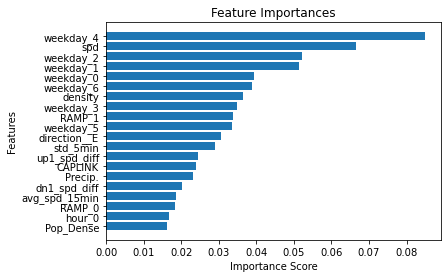

In [77]:
plt.barh(range(len(featureScores)), featureScores, tick_label=featureNames)
plt.gca().invert_yaxis()
plt.title('feature importance')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importances')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle = True, random_state=10)

print (X_train.shape,y_train.shape)
print (X_test.shape,y_test.shape,"\n")
X_train = xgb.DMatrix(X_train,label=y_train,feature_names=feature_names)
X_test =  xgb.DMatrix(X_test,label=y_test,feature_names=feature_names)
# params = {
#     'n_estimators': 2000,
#     'max_depth':6,
#     'reg_lambda': 0.0,
#     'reg_alpha':1.0
# }

params = {
#     'learning_rate': 0.1,
#     'n_estimators':1000,
#     'max_depth':7,
#     'min_child_weight':5,
#     'gamma':0.4,
#     'subsample':0.8,
#     'colsample_bytree':0.8,
#     'objective': 'binary:logistic',
#     'nthread':4,
#     'scale_pos_weight':1,
#     'seed':27
    'learning_rate':0.1,      
    'max_depth':7,
    'min_child_weight': 5,
    'gamma':0.4,
    'reg_lambda': 1.0,
    'reg_alpha':0.0,
    'scale_pos_weight':1.0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'eta':0.5
}

booster = xgb.train(params,X_train)

y_pred_test = np.round(booster.predict(X_test))
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
print ('Test F1:',f1_score(y_test,y_pred_test))
print ('Test Precision:',precision_score(y_test,y_pred_test))
print ('Test Recall:',recall_score(y_test,y_pred_test))
y_pred_test = booster.predict(X_test)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))

num_accidents_predicted_correctly = np.sum((y_test > 0) * (y_pred_test > 0))
num_accidents = np.sum(y_test > 0)

print(num_accidents_predicted_correctly)
print(num_accidents,"\n")

print ('Fraction Predicted:',num_accidents_predicted_correctly/float(num_accidents))
print ('Fraction False Alarm',(np.sum(y_pred_test>0) - num_accidents_predicted_correctly)/float(num_accidents))
y_pred_train = np.round(booster.predict(X_train))
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train F1:',f1_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = booster.predict(X_train)
print ('Train AUC:',roc_auc_score(y_train,y_pred_train))

(19267, 72) (19267,)
(10376, 72) (10376,) 

Test Accuracy: 0.837124132613724
Test F1: 0.38768115942028986
Test Precision: 0.6966145833333334
Test Recall: 0.26857429718875503
Test AUC: 0.7922420538547319
1992
1992 

Fraction Predicted: 1.0
Fraction False Alarm 4.208835341365462
Train Accuracy: 0.8609539627342088
Train F1: 0.46939988116458703
Train Precision: 0.799055967633176
Train Recall: 0.3323051037577117
Train AUC: 0.8389009966571391


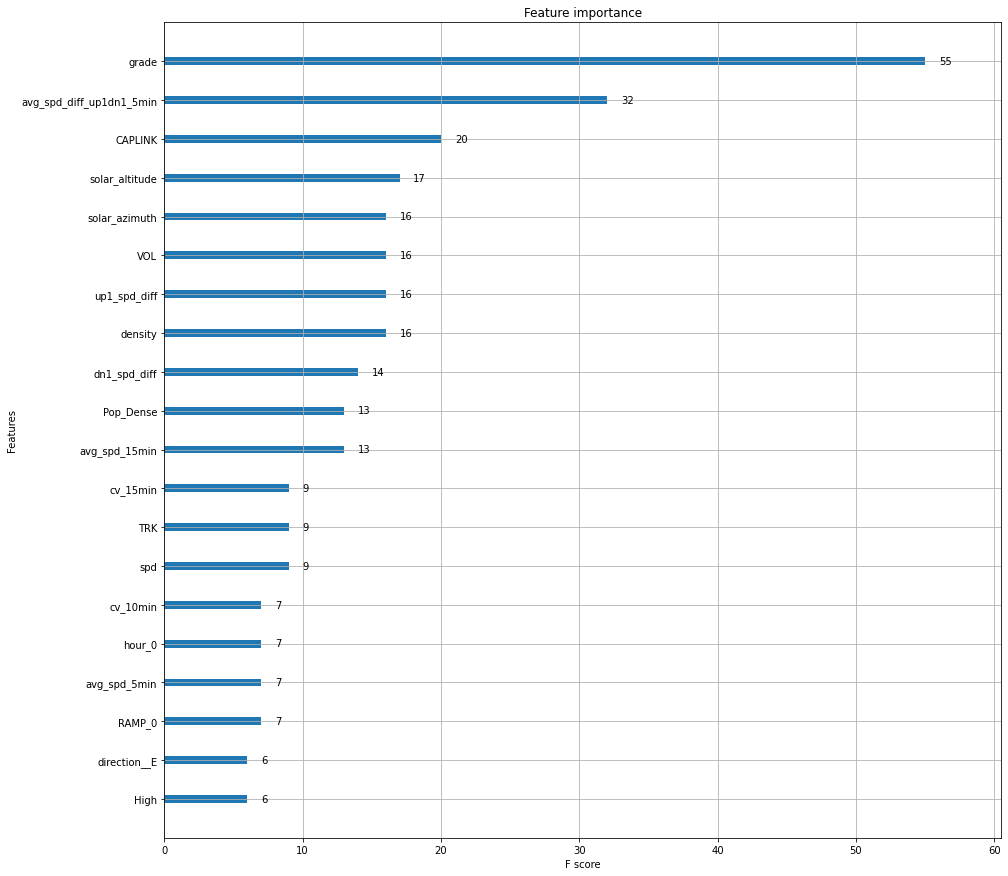

In [133]:
plt.figure(figsize=(15,15))
xgb.plot_importance(booster,ax=plt.gca(),importance_type='weight', max_num_features=20)

In [69]:
dtrain1 = xgb.DMatrix(xtrain,label=ytrain,feature_names=feature_names)
dtest1 =  xgb.DMatrix(xtest,label=ytest,feature_names=feature_names)

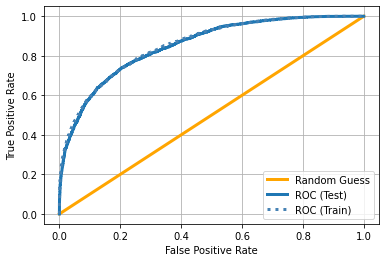

In [70]:
y_pred_test = booster.predict(dtest1)

fpr, tpr, thresholds = roc_curve(ytest,y_pred_test)

y_pred_train = booster.predict(dtrain1)
fpr_train, tpr_train, thresholds_train = roc_curve(ytrain,y_pred_train)
fig,ax = plt.subplots()
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange',lw=3)
plt.plot(fpr,tpr,label='ROC (Test)',lw=3)
plt.plot(fpr_train,tpr_train,'r:',label='ROC (Train)',color='steelblue',lw=3)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

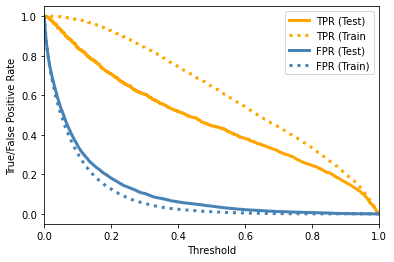

In [53]:
plt.plot(thresholds,tpr,'r-',label='TPR (Test)',color='orange',lw=3)
plt.plot(thresholds_train,tpr_train,'r:',label='TPR (Train',color='orange',lw=3)
plt.plot(thresholds,fpr,'r-',label='FPR (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,fpr_train,'r:',label='FPR (Train)',color='steelblue',lw=3)
plt.gca().set_xbound(lower=0,upper=1)
plt.xlabel('Threshold')
plt.ylabel('True/False Positive Rate')
plt.legend()

'3.2.2'

<Figure size 1080x1080 with 0 Axes>

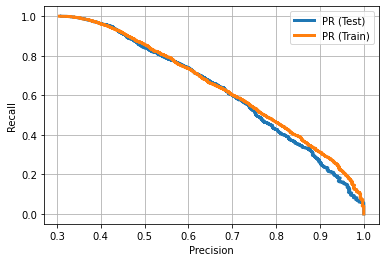

In [72]:
plt.figure(figsize=(15,15))

y_pred_test = booster.predict(dtest1)
y_pred_train = booster.predict(dtrain1)

precision,recall,thresholds = precision_recall_curve(ytest,y_pred_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(ytrain,y_pred_train)
fig,ax = plt.subplots()
plt.plot(precision,recall,label='PR (Test)',lw=3)
plt.plot(precision_train,recall_train,label='PR (Train)',lw=3)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()
plt.legend()
plt.matplotlib.__version__

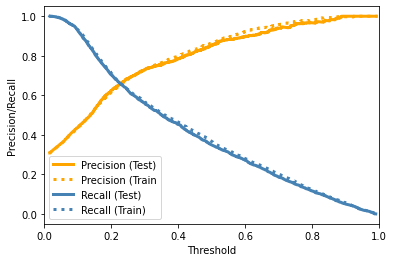

In [74]:
plt.plot(thresholds,precision[:-1],'r-',label='Precision (Test)',color='orange',lw=3)
plt.plot(thresholds_train,precision_train[:-1],'r:',label='Precision (Train',color='orange',lw=3)
plt.plot(thresholds,recall[:-1],'r-',label='Recall (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,recall_train[:-1],'r:',label='Recall (Train)',color='steelblue',lw=3)
#plt.plot([0,1],[0,1],'k-',lw=2)
plt.gca().set_xbound(lower=0,upper=1)
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()

In [88]:
y_pred_test = booster.predict(dtest) > 0.32
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
print ('Test F1:',f1_score(y_test,y_pred_test))
print ('Test Precision:',precision_score(y_test,y_pred_test))
print ('Test Recall:',recall_score(y_test,y_pred_test))
y_pred_test = booster.predict(dtest)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))
print ('Test AP:',average_precision_score(y_test,y_pred_test))

y_pred_train = booster.predict(dtrain) > 0.32
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train F1:',f1_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = booster.predict(dtrain)
print ('Train AUC:',roc_auc_score(y_train,y_pred_train))
print ('Test AP:',average_precision_score(y_train,y_pred_train))

Test Accuracy: 0.8738434849653045
Test F1: 0.6604409857328144
Test Precision: 0.6626756897449245
Test Recall: 0.6582213029989659
Test AUC: 0.8884211617835381
Test AP: 0.7322911671130392
Train Accuracy: 0.9306067369076659
Train F1: 0.81712488031733
Train Precision: 0.8101437483048549
Train Recall: 0.8242273730684326
Train AUC: 0.968491820601475
Test AP: 0.9052515543164572


In [96]:
df_1 = pd.concat([df1, ndf1])
df_1 = df_1.sample(frac=1).reset_index(drop=True)

In [99]:
df_1['density'] = df['VOL']/df['spd']
ndf1['density'] = ndf1['VOL']/ndf1['spd']

Density - Speed


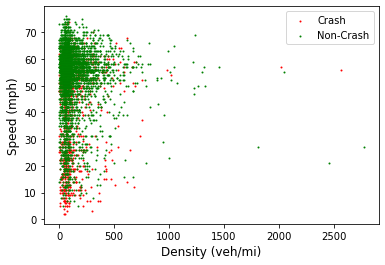

<Figure size 432x288 with 0 Axes>

In [100]:
non_crash = df_1[df_1['target']==0]
crash = df_1[df_1['target']==1]
print('Density - Speed')
plt.scatter(crash['density'], crash['spd'],s=1, color='r', label='Crash')

plt.scatter(non_crash['density'], non_crash['spd'], s=1, color='g', label ='Non-Crash')

plt.legend()
plt.xlabel('Density (veh/mi)', fontsize=12)
plt.ylabel('Speed (mph)', fontsize=12)

plt.show()

plt.clf()

In [83]:
df_1['volume'] = df_1['VOL']+df_1['TRK']

Flow - Speed


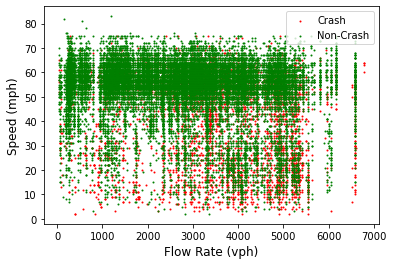

<Figure size 432x288 with 0 Axes>

In [101]:
non_crash = df_1[df_1['target']==0]
crash = df_1[df_1['target']==1]
print('Flow - Speed')
plt.scatter(crash['VOL'], crash['spd'],s=1, color='red', label = 'Crash')
plt.scatter(non_crash['VOL'], non_crash['spd'], s=1, color='green', label = 'Non-Crash')
plt.legend()
plt.xlabel('Flow Rate (vph)', fontsize=12)
plt.ylabel('Speed (mph)', fontsize=12)
plt.show()
plt.clf()

Flow - Speed


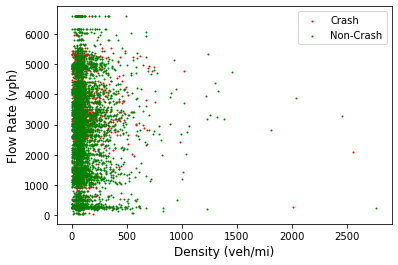

<Figure size 432x288 with 0 Axes>

In [102]:
non_crash = df_1[df_1['target']==0]
crash = df_1[df_1['target']==1]
print('Flow - Speed')
plt.scatter(crash['density'], crash['VOL'],s=1, color='r', label='Crash')
plt.scatter(non_crash['density'], non_crash['VOL'], s=1, color='g', label='Non-Crash')
plt.legend()
plt.xlabel('Density (veh/mi)', fontsize=12)
plt.ylabel('Flow Rate (vph)', fontsize=12)
plt.show()
plt.clf()

Azimuth - Altitude


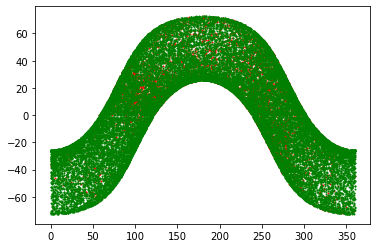

<Figure size 432x288 with 0 Axes>

In [89]:
non_crash = df_1[df_1['target']==0]
crash = df_1[df_1['target']==1]
print('Azimuth - Altitude')
plt.scatter(crash['solar_azimuth'], crash['solar_altitude'],s=1, color='r')
plt.scatter(non_crash['solar_azimuth'], non_crash['solar_altitude'], s=1, color='g')
plt.show()
plt.clf()

In [ ]:
df_1['density1'] = (df['VOL']/df['LANES'])/df['spd']


In [59]:
pd.Series(df.columns)


0                         Unnamed: 0
1                                DAY
2                             KILLED
3                            INJURED
4                           PED_KILL
5                            PED_INJ
6                           SEVERITY
7                            ALCOHOL
8                             HAZMAT
9                         CRASH_TYPE
10                         VEH_COUNT
11                          LOCATION
12                           LOC_DIR
13                                MP
14                           RD_SURF
15                         SURF_COND
16                             LIGHT
17                           WEATHER
18                            RD_DIV
19                          RD_WRKZN
20                        TIME_ROUND
21                               TMC
22                         timestamp
23                           tmc_dn1
24                           tmc_dn2
25                           tmc_up1
26                           tmc_up2
2

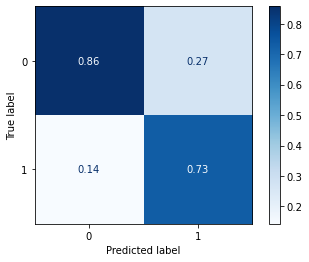

In [76]:
from sklearn.metrics import plot_confusion_matrix
clf = xgb.XGBClassifier(random_state=0)
clf.fit(X_train, y_train)

disp = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues,normalize='pred')

print(disp)
plt.show()

In [67]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier()

In [68]:
from numpy import mean
from sklearn.model_selection import RepeatedStratifiedKFold
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(xgb_model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.82352


In [89]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
%time xgb_model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.720425	validation_0-error:0.171018	validation_1-auc:0.716436	validation_1-error:0.172032
[1]	validation_0-auc:0.728217	validation_0-error:0.171018	validation_1-auc:0.723815	validation_1-error:0.172032
[2]	validation_0-auc:0.743235	validation_0-error:0.164322	validation_1-auc:0.741329	validation_1-error:0.167502
[3]	validation_0-auc:0.745612	validation_0-error:0.164063	validation_1-auc:0.744368	validation_1-error:0.16702
[4]	validation_0-auc:0.749759	validation_0-error:0.163336	validation_1-auc:0.746905	validation_1-error:0.166827
[5]	validation_0-auc:0.755105	validation_0-error:0.16344	validation_1-auc:0.751274	validation_1-error:0.167309
[6]	validation_0-auc:0.756008	validation_0-error:0.163232	validation_1-auc:0.752017	validation_1-error:0.166924
[7]	validation_0-auc:0.758471	validation_0-error:0.163492	validation_1-auc:0.752827	validation_1-error:0.16702
[8]	validation_0-auc:0.758833	validation_0-error:0.163336	validation_1-auc:0.753137	validation_1-error:0.16

XGBClassifier()

In [55]:
shap_values = shap.TreeExplainer(xgb_model1).shap_values(x1)

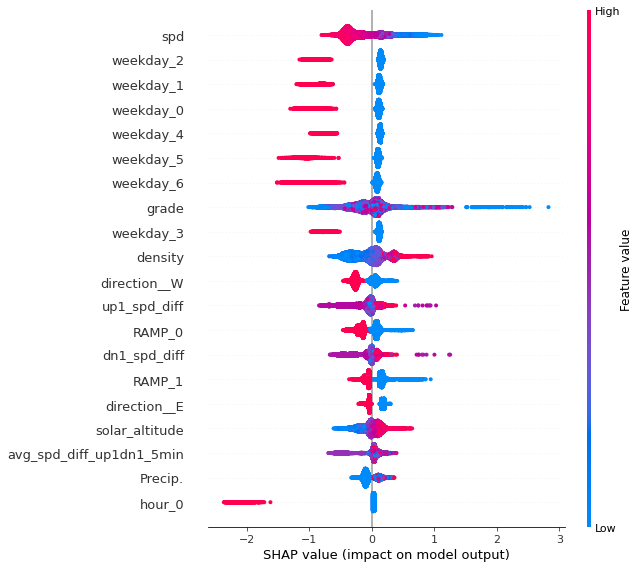

In [56]:
shap.summary_plot(shap_values, x1)

In [57]:
shap_values = shap.TreeExplainer(booster).shap_values(x1)

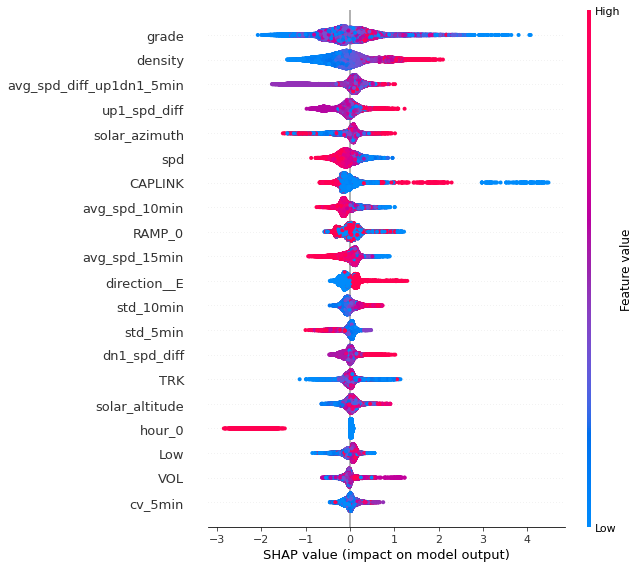

In [58]:
shap.summary_plot(shap_values, x1)

In [115]:
df_E = df[df['direction_']=='E'].sort_values(by='MP')
df_W = df[df['direction_']=='W'].sort_values(by='MP')

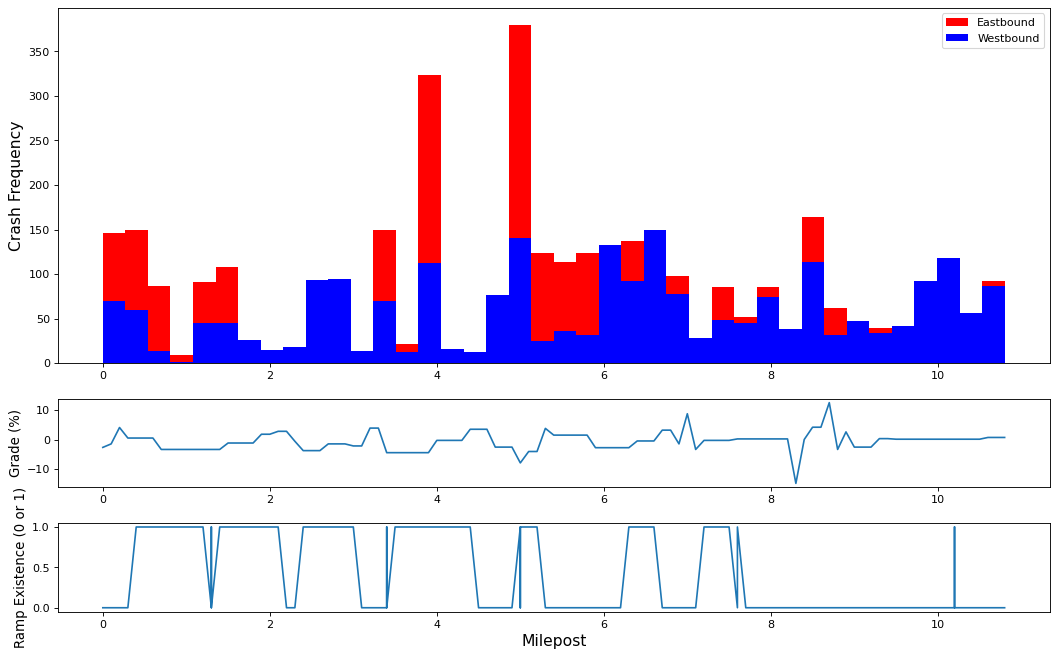

In [129]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


def annotate_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=True, labelleft=True)

fig = plt.figure(figsize=(16, 10), dpi= 80)

#fig.suptitle("Controlling subplot sizes with width_ratios and height_ratios")

legend=['Eastbound', 'Westbound']
gs = GridSpec(3, 1, height_ratios=[4, 1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

ax1.hist([df_E['MP'], df_W['MP']], 40, histtype='stepfilled', orientation='vertical', color =['blue', 'red'])
ax2.plot(df_E['MP'], df_E['grade'])
ax3.plot(df_E['MP'], df_E['RAMP'])

ax1.set_ylabel('Crash Frequency', fontsize=14)
ax2.set_ylabel('Grade (%)', fontsize = 12)
ax3.set_ylabel('Ramp Existence (0 or 1)', fontsize= 12)
ax3.set_xlabel('Milepost', fontsize=14)

ax1.legend(legend)

# xlabels = ax1.get_xticks().tolist()
# ax1.set_xticklabels(xlabels)

plt.show()

In [ ]:
shap_values = shap.TreeExplainer(model).shap_values(X)